# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Deep Learning. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string

from sklearn.preprocessing import *
from sklearn.pipeline import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import *

import os
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import log_loss
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

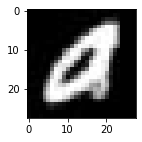

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

### Preprocessing

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [6]:
def get_dataset(data_dir, data_transforms ):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [7]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms)

In [8]:
print('Classes: ',  classes)

Classes:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
print('The datasets have: ',  dataset_sizes ," images")

The datasets have:  {'train': 65000, 'test': 13000}  images


Посмотрим на наши картиночки из учебной выборки

In [10]:
def imshow(img):
    img = img / 2 + 0.5      # unnormalize
    #img = np.transpose(img, axes=(1, 0, 2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

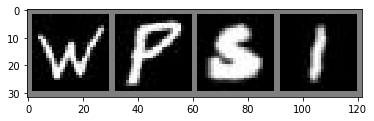

    w     p     s     i


In [11]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
images = [np.transpose(pic, axes=(0, 2, 1)) for pic in images]
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

## 3 слоя

### Подберем batch_size и learning_rate

In [12]:
batch_size = [50, 100, 200, 500, 1000]
error = []

In [13]:
def get_dataset(data_dir, data_transforms, batch_s):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_s,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 26),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net = Net()

In [15]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.99))

Я буду в первых двух заданиях строить с 2мя эпохами, так как даже 5 эпох приходится очень долго ждать.

In [16]:
acc = []

In [17]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 2.716
[1,   200] loss: 1.614
[1,   300] loss: 1.221
[1,   400] loss: 1.031
[1,   500] loss: 0.988
[1,   600] loss: 0.885
[1,   700] loss: 0.835
[1,   800] loss: 0.821
[1,   900] loss: 0.790
[1,  1000] loss: 0.776
[1,  1100] loss: 0.706
[1,  1200] loss: 0.682
[1,  1300] loss: 0.660
[2,   100] loss: 0.613
[2,   200] loss: 0.596
[2,   300] loss: 0.593
[2,   400] loss: 0.560
[2,   500] loss: 0.583
[2,   600] loss: 0.552
[2,   700] loss: 0.565
[2,   800] loss: 0.530
[2,   900] loss: 0.525
[2,  1000] loss: 0.520
[2,  1100] loss: 0.503
[2,  1200] loss: 0.513
[2,  1300] loss: 0.471
Finished Training
Accuracy: 83 %
Batch size:  100
[1,   100] loss: 0.426
[1,   200] loss: 0.408
[1,   300] loss: 0.421
[1,   400] loss: 0.408
[1,   500] loss: 0.396
[1,   600] loss: 0.422
[2,   100] loss: 0.371
[2,   200] loss: 0.355
[2,   300] loss: 0.364
[2,   400] loss: 0.356
[2,   500] loss: 0.349
[2,   600] loss: 0.345
Finished Training
Accuracy: 86 %
Batch size:  200
[1,   100]

Learning rate = 0.0001  --- 3 layers


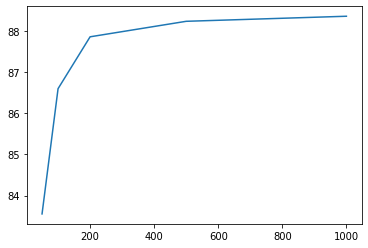

In [18]:
print("Learning rate = 0.0001  --- 3 layers")
plt.plot(batch_size, acc)

In [19]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [20]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    error.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 0.390
[1,   200] loss: 0.420
[1,   300] loss: 0.426
[1,   400] loss: 0.447
[1,   500] loss: 0.446
[1,   600] loss: 0.448
[1,   700] loss: 0.454
[1,   800] loss: 0.440
[1,   900] loss: 0.415
[1,  1000] loss: 0.411
[1,  1100] loss: 0.423
[1,  1200] loss: 0.411
[1,  1300] loss: 0.410
[2,   100] loss: 0.325
[2,   200] loss: 0.336
[2,   300] loss: 0.336
[2,   400] loss: 0.345
[2,   500] loss: 0.330
[2,   600] loss: 0.326
[2,   700] loss: 0.337
[2,   800] loss: 0.359
[2,   900] loss: 0.317
[2,  1000] loss: 0.337
[2,  1100] loss: 0.335
[2,  1200] loss: 0.354
[2,  1300] loss: 0.341
Finished Training
Accuracy: 86 %
Batch size:  100
[1,   100] loss: 0.208
[1,   200] loss: 0.197
[1,   300] loss: 0.218
[1,   400] loss: 0.219
[1,   500] loss: 0.236
[1,   600] loss: 0.222
[2,   100] loss: 0.169
[2,   200] loss: 0.178
[2,   300] loss: 0.174
[2,   400] loss: 0.184
[2,   500] loss: 0.186
[2,   600] loss: 0.203
Finished Training
Accuracy: 88 %
Batch size:  200
[1,   100]

Learning rate = 0.0005  --- 3 layers


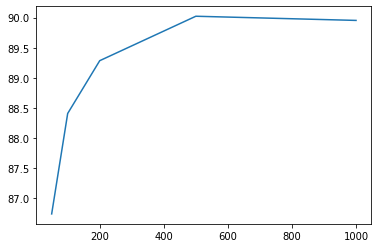

In [21]:
print("Learning rate = 0.0005  --- 3 layers")
plt.plot(batch_size, error)

Для 3х скрытых слоев лучшими значениями оказались learning_rate = 0.0005 и batch_size = 500. Можно объяснить это так: чем мельче кусок данных, на котором мы обучаем модель, тем лучше она обучается. Но важно не переобучится (упасть в локальный минимум?), поэтому learning_rate = 0.0005. 

### Посмотрим на лучшую нейронную сеть с другими функциями активации. 

In [22]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 300),
            nn.Sigmoid(),
            nn.Linear(300, 200),
            nn.Sigmoid(),
            nn.Linear(200, 26),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net2 = Net2()

In [23]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)

In [24]:
optimizer = torch.optim.Adam(net2.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [25]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 3.190
[1,    20] loss: 3.034
[1,    30] loss: 2.879
[1,    40] loss: 2.721
[1,    50] loss: 2.563
[1,    60] loss: 2.399
[2,    10] loss: 2.179
[2,    20] loss: 2.046
[2,    30] loss: 1.928
[2,    40] loss: 1.817
[2,    50] loss: 1.712
[2,    60] loss: 1.634
Finished Training


In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 62 %


In [27]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 300),
            nn.Tanh(),
            nn.Linear(300, 200),
            nn.Tanh(),
            nn.Linear(200, 26),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net3 = Net3()

In [28]:
optimizer = torch.optim.Adam(net3.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [29]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 2.537
[1,    20] loss: 1.838
[1,    30] loss: 1.504
[1,    40] loss: 1.293
[1,    50] loss: 1.176
[1,    60] loss: 1.053
[2,    10] loss: 0.936
[2,    20] loss: 0.894
[2,    30] loss: 0.846
[2,    40] loss: 0.801
[2,    50] loss: 0.787
[2,    60] loss: 0.762
Finished Training


In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 78 %


Как мы видим, что если изменим функцию активации в нейронной сети с подобранными параметрами, то accuracy очень сильно снижается, что и логично, так как ReLU и сигмоида с тангенсом имеют абсолютно разные алгоритмы введения нелинейности, что могло повлиять на результат. 

### Посмотрим на модель с подобранными параметрами с другим числом нейронов.

In [31]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 26),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net4 = Net4()

In [32]:
optimizer = torch.optim.Adam(net4.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [33]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 2.647
[1,    20] loss: 1.480
[1,    30] loss: 1.088
[1,    40] loss: 0.880
[1,    50] loss: 0.797
[1,    60] loss: 0.702
[2,    10] loss: 0.574
[2,    20] loss: 0.566
[2,    30] loss: 0.549
[2,    40] loss: 0.509
[2,    50] loss: 0.491
[2,    60] loss: 0.486
Finished Training


In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 84 %


Снова accuracy стала ниже, но уже не так сильно. Попробуем взять немного другие.

In [35]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net5 = Net5()

In [36]:
err = []

In [37]:
optimizer = torch.optim.Adam(net5.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [63]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

err.append(100 * correct / total)
            
print('Accuracy: %d %%' % (100 * correct / total))

Finished Training
Accuracy: 91 %


Видим, что accuracy стала значительно лучше.

### Посмотрим на модель с подобранными параметрами с функциями регуляризации.

In [112]:
weights = [0.0001, 0.0005, 0.005, 0.5]

In [113]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)

In [117]:
accur = []

for weight in weights:
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.99), weight_decay=weight)
    print('Weight_decay: ', weight)
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accur.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Weight_decay:  0.0001
[1,    10] loss: 2.306
[1,    20] loss: 1.438
[1,    30] loss: 1.086
[1,    40] loss: 0.920
[1,    50] loss: 0.821
[1,    60] loss: 0.739
[2,    10] loss: 0.627
[2,    20] loss: 0.586
[2,    30] loss: 0.550
[2,    40] loss: 0.518
[2,    50] loss: 0.510
[2,    60] loss: 0.492
Finished Training
Accuracy: 84 %
Weight_decay:  0.0005
[1,    10] loss: 0.449
[1,    20] loss: 0.415
[1,    30] loss: 0.442
[1,    40] loss: 0.418
[1,    50] loss: 0.389
[1,    60] loss: 0.399
[2,    10] loss: 0.346
[2,    20] loss: 0.336
[2,    30] loss: 0.345
[2,    40] loss: 0.339
[2,    50] loss: 0.338
[2,    60] loss: 0.333
Finished Training
Accuracy: 87 %
Weight_decay:  0.005
[1,    10] loss: 0.307
[1,    20] loss: 0.332
[1,    30] loss: 0.349
[1,    40] loss: 0.348
[1,    50] loss: 0.359
[1,    60] loss: 0.375
[2,    10] loss: 0.341
[2,    20] loss: 0.355
[2,    30] loss: 0.358
[2,    40] loss: 0.367
[2,    50] loss: 0.365
[2,    60] loss: 0.372
Finished Training
Accuracy: 87 %
Weight_d

Learning rate = 0.0005, batch size = 1000  --- 3 layers


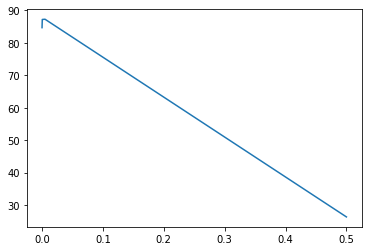

In [118]:
print("Learning rate = 0.0005, batch size = 1000  --- 3 layers")
plt.plot(weights, accur)

## 2 слоя

In [78]:
class Net_(nn.Module):
    def __init__(self):
        super(Net_, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 256),
            nn.ReLU(),
            nn.Linear(256, 26),
            nn.ReLU(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net_ = Net_()

In [79]:
criterion = nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(net_.parameters(), lr=0.0001, betas=(0.9, 0.99))

In [80]:
acc_ = []

In [81]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net_(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 2.642
[1,   200] loss: 1.799
[1,   300] loss: 1.406
[1,   400] loss: 1.224
[1,   500] loss: 1.145
[1,   600] loss: 1.059
[1,   700] loss: 1.008
[1,   800] loss: 0.986
[1,   900] loss: 0.954
[1,  1000] loss: 0.879
[1,  1100] loss: 0.909
[1,  1200] loss: 0.853
[1,  1300] loss: 0.847
[2,   100] loss: 0.816
[2,   200] loss: 0.776
[2,   300] loss: 0.747
[2,   400] loss: 0.751
[2,   500] loss: 0.703
[2,   600] loss: 0.741
[2,   700] loss: 0.739
[2,   800] loss: 0.714
[2,   900] loss: 0.703
[2,  1000] loss: 0.690
[2,  1100] loss: 0.709
[2,  1200] loss: 0.657
[2,  1300] loss: 0.653
Finished Training
Accuracy: 79 %
Batch size:  100
[1,   100] loss: 0.622
[1,   200] loss: 0.589
[1,   300] loss: 0.587
[1,   400] loss: 0.597
[1,   500] loss: 0.575
[1,   600] loss: 0.579
[2,   100] loss: 0.551
[2,   200] loss: 0.524
[2,   300] loss: 0.554
[2,   400] loss: 0.539
[2,   500] loss: 0.519
[2,   600] loss: 0.517
Finished Training
Accuracy: 82 %
Batch size:  200
[1,   100]

Learning rate = 0.0001  --- 2 layers


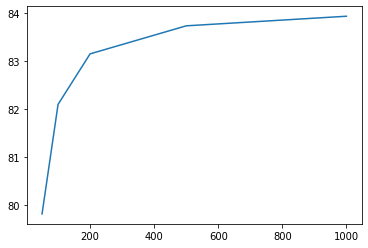

In [82]:
print("Learning rate = 0.0001  --- 2 layers")
plt.plot(batch_size, acc_)

In [83]:
optimizer = torch.optim.Adam(net_.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [84]:
error_ = []

In [85]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net_(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    error_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 0.516
[1,   200] loss: 0.584
[1,   300] loss: 0.544
[1,   400] loss: 0.599
[1,   500] loss: 0.589
[1,   600] loss: 0.595
[1,   700] loss: 0.568
[1,   800] loss: 0.543
[1,   900] loss: 0.572
[1,  1000] loss: 0.541
[1,  1100] loss: 0.568
[1,  1200] loss: 0.540
[1,  1300] loss: 0.540
[2,   100] loss: 0.435
[2,   200] loss: 0.475
[2,   300] loss: 0.446
[2,   400] loss: 0.481
[2,   500] loss: 0.510
[2,   600] loss: 0.488
[2,   700] loss: 0.510
[2,   800] loss: 0.483
[2,   900] loss: 0.498
[2,  1000] loss: 0.487
[2,  1100] loss: 0.500
[2,  1200] loss: 0.502
[2,  1300] loss: 0.520
Finished Training
Accuracy: 82 %
Batch size:  100
[1,   100] loss: 0.374
[1,   200] loss: 0.365
[1,   300] loss: 0.362
[1,   400] loss: 0.367
[1,   500] loss: 0.384
[1,   600] loss: 0.371
[2,   100] loss: 0.318
[2,   200] loss: 0.330
[2,   300] loss: 0.327
[2,   400] loss: 0.359
[2,   500] loss: 0.365
[2,   600] loss: 0.351
Finished Training
Accuracy: 83 %
Batch size:  200
[1,   100]

Learning rate = 0.0005  --- 2 layers


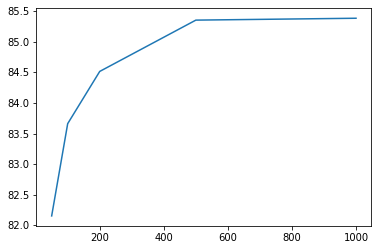

In [86]:
print("Learning rate = 0.0005  --- 2 layers")
plt.plot(batch_size, error_)

Лучший результат снова при batch_size = 1000 и learning_rate = 0.0005.

### Посмотрим на лучшую нейронную сеть с другими функциями активации. 

In [90]:
class Net2_(nn.Module):
    def __init__(self):
        super(Net2_, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 256),
            nn.Sigmoid(),
            nn.Linear(256, 26),
            nn.Sigmoid(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net2_ = Net2_()

In [91]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)

In [93]:
optimizer = torch.optim.Adam(net2_.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [94]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net2_(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 3.155
[1,    20] loss: 3.017
[1,    30] loss: 2.944
[1,    40] loss: 2.896
[1,    50] loss: 2.851
[1,    60] loss: 2.817
[2,    10] loss: 2.771
[2,    20] loss: 2.748
[2,    30] loss: 2.731
[2,    40] loss: 2.717
[2,    50] loss: 2.702
[2,    60] loss: 2.685
Finished Training


In [95]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2_(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 67 %


In [96]:
class Net3_(nn.Module):
    def __init__(self):
        super(Net3_, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 256),
            nn.Tanh(),
            nn.Linear(256, 26),
            nn.Tanh(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net3_ = Net3_()

In [97]:
optimizer = torch.optim.Adam(net3_.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [98]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net3_(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 2.708
[1,    20] loss: 2.497
[1,    30] loss: 2.443
[1,    40] loss: 2.401
[1,    50] loss: 2.343
[1,    60] loss: 2.283
[2,    10] loss: 2.170
[2,    20] loss: 2.110
[2,    30] loss: 2.061
[2,    40] loss: 2.018
[2,    50] loss: 1.983
[2,    60] loss: 1.961
Finished Training


In [99]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net3_(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 72 %


### Посмотрим на модель с подобранными параметрами с другим числом нейронов.

In [103]:
class Net4_(nn.Module):
    def __init__(self):
        super(Net4_, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
            nn.ReLU(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net4_ = Net4_()

In [104]:
optimizer = torch.optim.Adam(net4_.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [105]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net4_(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
     
print('Finished Training')

[1,    10] loss: 2.324
[1,    20] loss: 1.309
[1,    30] loss: 1.002
[1,    40] loss: 0.877
[1,    50] loss: 0.808
[1,    60] loss: 0.727
[2,    10] loss: 0.617
[2,    20] loss: 0.591
[2,    30] loss: 0.564
[2,    40] loss: 0.517
[2,    50] loss: 0.513
[2,    60] loss: 0.488
Finished Training


In [106]:
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net4_(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 84 %


In [107]:
class Net5_(nn.Module):
    def __init__(self):
        super(Net5_, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(2352),
            nn.Linear(28*28*3, 300),
            nn.ReLU(),
            nn.Linear(300, 26),
            nn.ReLU(),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x
    
net5_ = Net5_()

In [108]:
optimizer = torch.optim.Adam(net5_.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [109]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net5_(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net5_(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

err.append(100 * correct / total)
            
print('Accuracy: %d %%' % (100 * correct / total))

Finished Training
Accuracy: 82 %


### Посмотрим на модель с подобранными параметрами с функциями регуляризации.

In [119]:
accur_ = []

for weight in weights:
    optimizer = torch.optim.Adam(net_.parameters(), lr=0.0005, betas=(0.9, 0.99), weight_decay=weight)
    print('Weight_decay: ', weight)
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net_(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accur_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Weight_decay:  0.0001
[1,    10] loss: 0.190
[1,    20] loss: 0.210
[1,    30] loss: 0.204
[1,    40] loss: 0.199
[1,    50] loss: 0.207
[1,    60] loss: 0.208
[2,    10] loss: 0.196
[2,    20] loss: 0.194
[2,    30] loss: 0.197
[2,    40] loss: 0.200
[2,    50] loss: 0.194
[2,    60] loss: 0.203
Finished Training
Accuracy: 85 %
Weight_decay:  0.0005
[1,    10] loss: 0.189
[1,    20] loss: 0.203
[1,    30] loss: 0.206
[1,    40] loss: 0.205
[1,    50] loss: 0.217
[1,    60] loss: 0.201
[2,    10] loss: 0.198
[2,    20] loss: 0.208
[2,    30] loss: 0.194
[2,    40] loss: 0.211
[2,    50] loss: 0.199
[2,    60] loss: 0.227
Finished Training
Accuracy: 85 %
Weight_decay:  0.005
[1,    10] loss: 0.177
[1,    20] loss: 0.126
[1,    30] loss: 0.125
[1,    40] loss: 0.143
[1,    50] loss: 0.158
[1,    60] loss: 0.169
[2,    10] loss: 0.176
[2,    20] loss: 0.189
[2,    30] loss: 0.205
[2,    40] loss: 0.211
[2,    50] loss: 0.242
[2,    60] loss: 0.247
Finished Training
Accuracy: 88 %
Weight_d

Learning rate = 0.0005, batch size = 1000  --- 2 layers


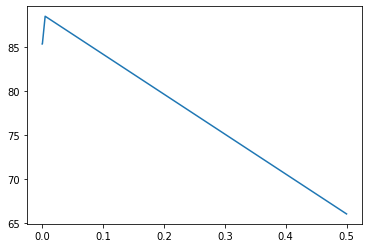

In [120]:
print("Learning rate = 0.0005, batch size = 1000  --- 2 layers")
plt.plot(weights, accur_)

Лучшей моделью оказалась модель с 3мя скрытыми слоями Net5.  

In [210]:
from sklearn.metrics import confusion_matrix

In [211]:
images, labels = data

In [212]:
all_labels = []
all_pred = []
all_images = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels = all_labels + list(labels)
        all_pred = all_pred + list(predicted)
        for im in images:
            all_images.append(list(im))

In [213]:
con_mat = confusion_matrix(all_labels, all_pred)
print('Confusion matrix: ', con_mat[1:27, 0:25])   

Confusion matrix:  [[  3 462   0   6   3   1  11   2   2   0   0   1   0   0   2   0   2   1
    1   1   0   0   0   0   0]
 [  1   1 476   0   9   0   3   0   0   0   0   3   0   0   3   0   0   1
    2   0   1   0   0   0   0]
 [  3   4   0 463   0   0   0   2   0   3   1   2   0   1  14   1   2   0
    1   0   1   0   1   0   0]
 [  0   2   7   0 476   1   4   0   1   0   0   0   0   0   0   0   1   0
    1   2   2   0   0   1   0]
 [  1   0   0   0   1 473   2   0   0   2   0   0   0   1   0  11   1   0
    0   6   0   0   0   1   1]
 [  9   8   0   1   0   3 409   0   0   5   1   0   1   0   0   0  55   0
    5   0   1   0   0   0   2]
 [  3   4   0   0   0   1   0 466   1   0   3   7   1  11   0   0   0   0
    0   1   0   0   0   1   1]
 [  0   0   0   0   0   2   0   0 390  16   0  83   0   0   0   0   1   0
    0   1   0   0   0   1   2]
 [  0   1   0   7   0   1   3   0   8 458   0   1   0   0   0   0   2   0
    5   6   2   3   2   0   1]
 [  2   1   1   1   1   2   0   7   

In [215]:
top = []
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        if (con_mat[i, j] > 10 and i != j):
            top.append([con_mat[i, j], classes[i], classes[j], i, j])
top.sort(reverse=True)
print('Top errors: ', top)

Top errors:  [[133, 'l', 'i', 11, 8], [83, 'i', 'l', 8, 11], [80, 'q', 'g', 16, 6], [55, 'g', 'q', 6, 16], [22, 'v', 'u', 21, 20], [19, 'y', 'v', 24, 21], [17, 's', 'g', 18, 6], [16, 'i', 'j', 8, 9], [14, 'd', 'o', 3, 14], [13, 'm', 'n', 12, 13], [13, 'a', 'q', 0, 16], [11, 'h', 'n', 7, 13], [11, 'f', 'p', 5, 15], [11, 'b', 'g', 1, 6]]


In [216]:
num_pics = 10    
for i in range(len(top)):
    if (num_pics > 0):
        print(top[i][1], top[i][2] )
        num_pics-=1

l i
i l
q g
g q
v u
y v
s g
i j
d o
m n


(28, 28, 3)


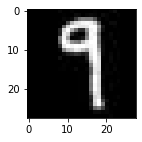

In [274]:
pic = plt.imread('images/train/g/g_01334.jpg') #перепутал с q
print(pic.shape)
 
pic = np.transpose(pic, axes=(1, 0, 2))
 
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

In [260]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net5(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(1000):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [261]:
list_with_accuracies = [(classes[i], class_correct[i] / class_total[i]) for i in range(len(classes))]
list_with_accuracies.sort(key=lambda x: x[1], reverse=True)

for i in range(len(classes)):
    print('Precision of ', list_with_accuracies[i][0], ' = ', np.round(list_with_accuracies[i][1]*100, 1), '%', sep='')

Precision of o = 97.0%
Precision of w = 96.0%
Precision of e = 95.8%
Precision of p = 95.4%
Precision of m = 95.2%
Precision of x = 95.2%
Precision of c = 95.0%
Precision of f = 94.8%
Precision of t = 94.8%
Precision of u = 94.6%
Precision of s = 94.2%
Precision of z = 94.2%
Precision of h = 93.8%
Precision of k = 93.4%
Precision of n = 93.0%
Precision of d = 92.8%
Precision of r = 92.6%
Precision of b = 92.2%
Precision of j = 91.8%
Precision of v = 91.0%
Precision of a = 90.2%
Precision of y = 90.2%
Precision of g = 81.4%
Precision of i = 79.2%
Precision of q = 78.4%
Precision of l = 69.4%


Модель не идеально равномерно угадывает буквы, но чаще делает ошибки в тех, при чтении которых и люди могут допустить ошибку (l, i, g, q).

In [262]:
num = 0
sur_err = []
for i in range(len(classes)):
    if classes[i] == 'd':
        num = i
print('num: ', num)

sur_err_sum = 0
for i in range(con_mat.shape[1]):
    if (con_mat[i, num] > 5 and i != num):
        sur_err_sum += con_mat[i, num]
        sur_err.append([con_mat[i, num], classes[i], classes[num], i, num])
sur_err.sort(reverse=True)
print('Top errors: ',sur_err)

num_pics = 10    
for i in range(len(sur_err)):
    if (num_pics > 0):
        print(sur_err[i][1], sur_err[i][2] )
        num_pics -= 1
    
print('Precision of the surname: ', 100 * (1 - sur_err_sum/class_total[num]))

num:  3
Top errors:  [[7, 'j', 'd', 9, 3], [6, 'b', 'd', 1, 3]]
j d
b d
Precision of the surname:  97.39999999999999


### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### 1 сверточный слой

In [142]:
class ConvNet1(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet1, self).__init__()
        self.layer = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.BatchNorm2d(32), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        x = self.layer(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
in_dim = 6272
hid = 500
out_dim = 26       
ConvNet1 = ConvNet1(in_dim, hid, out_dim)

In [155]:
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(ConvNet1.parameters(), lr=0.0001, betas=(0.9, 0.99))

In [156]:
acc1 = []

In [158]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = ConvNet1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = ConvNet1(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc1.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 0.444
[1,   200] loss: 0.449
[1,   300] loss: 0.430
[1,   400] loss: 0.476
[1,   500] loss: 0.422
[1,   600] loss: 0.464
[1,   700] loss: 0.451
[1,   800] loss: 0.441
[1,   900] loss: 0.444
[1,  1000] loss: 0.461
[1,  1100] loss: 0.429
[1,  1200] loss: 0.478
[1,  1300] loss: 0.460
[2,   100] loss: 0.395
[2,   200] loss: 0.412
[2,   300] loss: 0.415
[2,   400] loss: 0.398
[2,   500] loss: 0.404
[2,   600] loss: 0.422
[2,   700] loss: 0.416
[2,   800] loss: 0.432
[2,   900] loss: 0.399
[2,  1000] loss: 0.410
[2,  1100] loss: 0.413
[2,  1200] loss: 0.408
[2,  1300] loss: 0.437
Finished Training
Accuracy: 85 %
Batch size:  100
[1,   100] loss: 0.363
[1,   200] loss: 0.368
[1,   300] loss: 0.346
[1,   400] loss: 0.387
[1,   500] loss: 0.366
[1,   600] loss: 0.359
[2,   100] loss: 0.348
[2,   200] loss: 0.353
[2,   300] loss: 0.342
[2,   400] loss: 0.357
[2,   500] loss: 0.348
[2,   600] loss: 0.366
Finished Training
Accuracy: 87 %
Batch size:  200
[1,   100]

In [159]:
optimizer = torch.optim.Adam(ConvNet1.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [160]:
acc1_ = []

In [161]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = ConvNet1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = ConvNet1(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc1_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 0.578
[1,   200] loss: 0.676
[1,   300] loss: 0.624
[1,   400] loss: 0.634
[1,   500] loss: 0.631
[1,   600] loss: 0.581
[1,   700] loss: 0.581
[1,   800] loss: 0.599
[1,   900] loss: 0.565
[1,  1000] loss: 0.573
[1,  1100] loss: 0.585
[1,  1200] loss: 0.595
[1,  1300] loss: 0.577
[2,   100] loss: 0.508
[2,   200] loss: 0.505
[2,   300] loss: 0.482
[2,   400] loss: 0.517
[2,   500] loss: 0.522
[2,   600] loss: 0.500
[2,   700] loss: 0.504
[2,   800] loss: 0.493
[2,   900] loss: 0.497
[2,  1000] loss: 0.545
[2,  1100] loss: 0.492
[2,  1200] loss: 0.502
[2,  1300] loss: 0.473
Finished Training
Accuracy: 83 %
Batch size:  100
[1,   100] loss: 0.415
[1,   200] loss: 0.401
[1,   300] loss: 0.377
[1,   400] loss: 0.416
[1,   500] loss: 0.398
[1,   600] loss: 0.420
[2,   100] loss: 0.362
[2,   200] loss: 0.377
[2,   300] loss: 0.397
[2,   400] loss: 0.388
[2,   500] loss: 0.380
[2,   600] loss: 0.394
Finished Training
Accuracy: 86 %
Batch size:  200
[1,   100]

Лучший результат у модели при learning_rate = 0.0005 и batch_size = 1000.

In [162]:
optimizer = torch.optim.Adam(ConvNet1.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [163]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 1000)

In [171]:
class ConvNet1_1(nn.Module):
    def __init__(self):
        super(ConvNet1_1, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(6272, 500)
        self.fc2 = nn.Linear(500, 26)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
        
ConvNet1_1 = ConvNet1_1()

In [173]:
optimizer = torch.optim.Adam(ConvNet1_1.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [174]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ConvNet1_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet1_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

Finished Training
Accuracy: 83 %


### 2 сверточных слоя

In [175]:
class ConvNet2(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet2, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
in_dim = 3136
hid = 500
out_dim = 26
ConvNet2 = ConvNet2(in_dim, hid, out_dim)

In [176]:
criterion = nn.CrossEntropyLoss()      
optimizer = torch.optim.Adam(ConvNet2.parameters(), lr=0.0001, betas=(0.9, 0.99))

In [177]:
acc2_ = []

In [178]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = ConvNet2(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = ConvNet2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc2_.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 1.971
[1,   200] loss: 1.069
[1,   300] loss: 0.851
[1,   400] loss: 0.708
[1,   500] loss: 0.612
[1,   600] loss: 0.561
[1,   700] loss: 0.531
[1,   800] loss: 0.527
[1,   900] loss: 0.504
[1,  1000] loss: 0.482
[1,  1100] loss: 0.459
[1,  1200] loss: 0.452
[1,  1300] loss: 0.430
[2,   100] loss: 0.376
[2,   200] loss: 0.407
[2,   300] loss: 0.378
[2,   400] loss: 0.368
[2,   500] loss: 0.373
[2,   600] loss: 0.375
[2,   700] loss: 0.352
[2,   800] loss: 0.358
[2,   900] loss: 0.355
[2,  1000] loss: 0.325
[2,  1100] loss: 0.342
[2,  1200] loss: 0.353
[2,  1300] loss: 0.325
Finished Training
Accuracy: 89 %
Batch size:  100
[1,   100] loss: 0.295
[1,   200] loss: 0.294
[1,   300] loss: 0.293
[1,   400] loss: 0.291
[1,   500] loss: 0.285
[1,   600] loss: 0.295
[2,   100] loss: 0.273
[2,   200] loss: 0.273
[2,   300] loss: 0.257
[2,   400] loss: 0.264
[2,   500] loss: 0.253
[2,   600] loss: 0.263
Finished Training
Accuracy: 91 %
Batch size:  200
[1,   100]

In [179]:
criterion = nn.CrossEntropyLoss()      
optimizer = torch.optim.Adam(ConvNet2.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [180]:
acc2 = []

In [181]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = ConvNet2(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = ConvNet2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc2.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 0.322
[1,   200] loss: 0.350
[1,   300] loss: 0.365
[1,   400] loss: 0.356
[1,   500] loss: 0.345
[1,   600] loss: 0.386
[1,   700] loss: 0.360
[1,   800] loss: 0.343
[1,   900] loss: 0.371
[1,  1000] loss: 0.345
[1,  1100] loss: 0.347
[1,  1200] loss: 0.378
[1,  1300] loss: 0.340
[2,   100] loss: 0.299
[2,   200] loss: 0.330
[2,   300] loss: 0.326
[2,   400] loss: 0.311
[2,   500] loss: 0.330
[2,   600] loss: 0.341
[2,   700] loss: 0.333
[2,   800] loss: 0.312
[2,   900] loss: 0.308
[2,  1000] loss: 0.307
[2,  1100] loss: 0.335
[2,  1200] loss: 0.327
[2,  1300] loss: 0.311
Finished Training
Accuracy: 89 %
Batch size:  100
[1,   100] loss: 0.242
[1,   200] loss: 0.254
[1,   300] loss: 0.248
[1,   400] loss: 0.248
[1,   500] loss: 0.264
[1,   600] loss: 0.272
[2,   100] loss: 0.221
[2,   200] loss: 0.226
[2,   300] loss: 0.234
[2,   400] loss: 0.252
[2,   500] loss: 0.249
[2,   600] loss: 0.244
Finished Training
Accuracy: 91 %
Batch size:  200
[1,   100]

In [182]:
class ConvNet2_1(nn.Module):
    def __init__(self):
        super(ConvNet2_1, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( 
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(3136, 500)
        self.fc2 = nn.Linear(500, 26)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

ConvNet2_1 = ConvNet2_1()

In [183]:
optimizer = torch.optim.Adam(ConvNet2_1.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [184]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)

In [186]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ConvNet2_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet2_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 0.344
[2,   100] loss: 0.297
Finished Training
Accuracy: 90 %


### 3 сверточных слоя

In [187]:
class ConvNet3(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet3, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential( 
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( 
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
in_dim = 1152
hid = 500
out_dim = 26    
ConvNet3 = ConvNet3(in_dim, hid, out_dim)

In [188]:
criterion = nn.CrossEntropyLoss()      
optimizer = torch.optim.Adam(ConvNet3.parameters(), lr=0.0001, betas=(0.9, 0.99))

In [189]:
acc3 = []

In [190]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = ConvNet3(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = ConvNet3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc3.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 2.941
[1,   200] loss: 1.646
[1,   300] loss: 1.140
[1,   400] loss: 0.933
[1,   500] loss: 0.810
[1,   600] loss: 0.700
[1,   700] loss: 0.627
[1,   800] loss: 0.594
[1,   900] loss: 0.534
[1,  1000] loss: 0.529
[1,  1100] loss: 0.495
[1,  1200] loss: 0.467
[1,  1300] loss: 0.448
[2,   100] loss: 0.427
[2,   200] loss: 0.419
[2,   300] loss: 0.415
[2,   400] loss: 0.397
[2,   500] loss: 0.386
[2,   600] loss: 0.376
[2,   700] loss: 0.372
[2,   800] loss: 0.360
[2,   900] loss: 0.360
[2,  1000] loss: 0.346
[2,  1100] loss: 0.324
[2,  1200] loss: 0.334
[2,  1300] loss: 0.329
Finished Training
Accuracy: 89 %
Batch size:  100
[1,   100] loss: 0.304
[1,   200] loss: 0.307
[1,   300] loss: 0.294
[1,   400] loss: 0.279
[1,   500] loss: 0.284
[1,   600] loss: 0.283
[2,   100] loss: 0.260
[2,   200] loss: 0.267
[2,   300] loss: 0.270
[2,   400] loss: 0.245
[2,   500] loss: 0.257
[2,   600] loss: 0.252
Finished Training
Accuracy: 91 %
Batch size:  200
[1,   100]

In [191]:
optimizer = torch.optim.Adam(ConvNet3.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [192]:
acc3_ = []

In [193]:
for batch in batch_size:
    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
    print('Batch size: ', batch)
    
    for epoch in range(2): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = ConvNet3(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
     
    print('Finished Training')
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = ConvNet3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc3.append(100 * correct / total)
            
    print('Accuracy: %d %%' % (100 * correct / total))

Batch size:  50
[1,   100] loss: 0.361
[1,   200] loss: 0.359
[1,   300] loss: 0.322
[1,   400] loss: 0.322
[1,   500] loss: 0.321
[1,   600] loss: 0.327
[1,   700] loss: 0.312
[1,   800] loss: 0.311
[1,   900] loss: 0.297
[1,  1000] loss: 0.299
[1,  1100] loss: 0.337
[1,  1200] loss: 0.259
[1,  1300] loss: 0.292
[2,   100] loss: 0.262
[2,   200] loss: 0.258
[2,   300] loss: 0.260
[2,   400] loss: 0.268
[2,   500] loss: 0.245
[2,   600] loss: 0.259
[2,   700] loss: 0.279
[2,   800] loss: 0.256
[2,   900] loss: 0.258
[2,  1000] loss: 0.260
[2,  1100] loss: 0.236
[2,  1200] loss: 0.234
[2,  1300] loss: 0.251
Finished Training
Accuracy: 91 %
Batch size:  100
[1,   100] loss: 0.206
[1,   200] loss: 0.182
[1,   300] loss: 0.198
[1,   400] loss: 0.204
[1,   500] loss: 0.198
[1,   600] loss: 0.199
[2,   100] loss: 0.178
[2,   200] loss: 0.179
[2,   300] loss: 0.188
[2,   400] loss: 0.192
[2,   500] loss: 0.183
[2,   600] loss: 0.191
Finished Training
Accuracy: 92 %
Batch size:  200
[1,   100]

Тут можно взять batch_size = 500 и learning_rate = 0.0005.

In [194]:
class ConvNet3_1(nn.Module):
    def __init__(self):
        super(ConvNet3_1, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( 
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( 
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(1152, 500)
        self.fc2 = nn.Linear(500, 26)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
ConvNet3_1 = ConvNet3_1()

In [195]:
optimizer = torch.optim.Adam(ConvNet3_1.parameters(), lr=0.0005, betas=(0.9, 0.99))

In [196]:
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)

In [197]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ConvNet3_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet3_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 1.263
[2,   100] loss: 0.408
Finished Training
Accuracy: 88 %


### BatchNorm and GroupNorm

Будем делать для модели с 2мя сверточными слоями, так как ее accuracy на подобранных параметрах не отличается от accuracy для модели с 3мя сверточными слоями, а времени займет меньше.

In [198]:
class ConvNet2_bn(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet2_bn, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1), 
            nn.Linear(in_features=3136, out_features=500), 
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(in_features=500, out_features=200),
            nn.ReLU(),
        )

        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
in_dim = 200
hid = 100
out_dim = 26
ConvNet2_bn = ConvNet2_bn(in_dim, hid, out_dim)

In [199]:
criterion = nn.CrossEntropyLoss()      #пробуем для лучших параметров модели с 2мя слоями
optimizer = torch.optim.Adam(ConvNet2_bn.parameters(), lr=0.0005, betas=(0.9, 0.99))
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)

In [202]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ConvNet2_bn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet2_bn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 0.199
[2,   100] loss: 0.158
Finished Training
Accuracy: 92 %


Ниже код для подбора batch_size для ConvNet2_bn, но он работает очень долго. В любом случае лучшими параметрами (из тех, на которых мы подбираем для каждой модели) окажутся те, на которых я запускаю эту модель в верхней ячейке. Для ConvNet2_gn лучшие параметры будут аналогичны, код там на подборе тоже долго работает.

In [203]:
#for batch in batch_size:
#    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
#    print('Batch size: ', batch)
    
#    for epoch in range(2): 

#        running_loss = 0.0
#        for i, data in enumerate(trainloader, 0):
#            inputs, labels = data

#            optimizer.zero_grad()

#            outputs = ConvNet2_bn(inputs)
#            loss = criterion(outputs, labels)
#            loss.backward()
#            optimizer.step()

#            running_loss += loss.item()
#            if i % 100 == 99:
#                print('[%d, %5d] loss: %.3f' %
#                      (epoch + 1, i + 1, running_loss / 100))
#                running_loss = 0.0
     
#    print('Finished Training')
    
#    dataiter = iter(testloader)
#    images, labels = dataiter.next()
    
#    correct = 0
#    total = 0
#    with torch.no_grad():
#        for data in testloader:
#            images, labels = data
#            outputs = ConvNet2_bn(images)
#            _, predicted = torch.max(outputs.data, 1)
#            total += labels.size(0)
#            correct += (predicted == labels).sum().item()
            
#    print('Accuracy: %d %%' % (100 * correct / total))

In [205]:
class ConvNet2_gn(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet2_gn, self).__init__()
        self.layer1 = nn.Sequential(
            nn.GroupNorm(3, 3),
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.GroupNorm(32, 32),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1), 
            nn.Linear(in_features=3136, out_features=500), 
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(in_features=500, out_features=200),
            nn.ReLU(),
        )

        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
in_dim = 200
hid = 100
out_dim = 26
ConvNet2_gn = ConvNet2_gn(in_dim, hid, out_dim)

In [206]:
criterion = nn.CrossEntropyLoss()      #пробуем для лучших параметров модели с 2мя слоями
optimizer = torch.optim.Adam(ConvNet2_gn.parameters(), lr=0.0005, betas=(0.9, 0.99))
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 500)

In [207]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ConvNet2_gn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet2_gn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 0.956
[2,   100] loss: 0.272
Finished Training
Accuracy: 91 %


Подбор для ConvNet2_gn:

In [204]:
#for batch in batch_size:
#    trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, batch)
    
#    print('Batch size: ', batch)
    
#    for epoch in range(2): 

#        running_loss = 0.0
#        for i, data in enumerate(trainloader, 0):
#            inputs, labels = data

#            optimizer.zero_grad()

#            outputs = ConvNet2_gn(inputs)
#            loss = criterion(outputs, labels)
#            loss.backward()
#            optimizer.step()

#            running_loss += loss.item()
#            if i % 100 == 99:
#                print('[%d, %5d] loss: %.3f' %
#                      (epoch + 1, i + 1, running_loss / 100))
#                running_loss = 0.0
     
#    print('Finished Training')
    
#    dataiter = iter(testloader)
#    images, labels = dataiter.next()
    
#    correct = 0
#    total = 0
#    with torch.no_grad():
#        for data in testloader:
#            images, labels = data
#            outputs = ConvNet2_gn(images)
#            _, predicted = torch.max(outputs.data, 1)
#            total += labels.size(0)
#            correct += (predicted == labels).sum().item()
            
#    print('Accuracy: %d %%' % (100 * correct / total))

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

In [224]:
class ConvNet2_bn1(nn.Module):
    def __init__(self,in_dim,hid,out_dim):
        super(ConvNet2_bn1, self).__init__()
        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1), 
            nn.Linear(in_features=3136, out_features=500), 
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(in_features=500, out_features=200),
            nn.ReLU(),
        )

        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        
    def forward(self, x):
        x1 = self.layer1(x)
        x1 = x1.reshape(x1.size(0), -1)
        x1 = self.dropout(x1)
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)
        return x1
    
in_dim = 200
hid = 100
out_dim = 26
ConvNet2_bn1 = ConvNet2_bn1(in_dim, hid, out_dim)

In [225]:
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(ConvNet2_bn1.parameters(), lr=0.0005, betas=(0.9, 0.99))
trainloader, testloader, classes, dataset_sizes=get_dataset('images',data_transforms, 310)

In [227]:
for epoch in range(6): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ConvNet2_bn1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
     
print('Finished Training')
    
dataiter = iter(testloader)
images, labels = dataiter.next()
    
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = ConvNet2_bn1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 0.169
[1,   200] loss: 0.166
[2,   100] loss: 0.136
[2,   200] loss: 0.146
[3,   100] loss: 0.121
[3,   200] loss: 0.125
[4,   100] loss: 0.099
[4,   200] loss: 0.114
[5,   100] loss: 0.089
[5,   200] loss: 0.105
[6,   100] loss: 0.078
[6,   200] loss: 0.086
Finished Training
Accuracy: 92 %


## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.